In [24]:
import pandas as pd
import numpy as np

# Load your dataset (change filename if needed)
sensor_data = pd.read_csv("sensor_data.csv")

def outlier_limits(data, column_name):
    Q1 = np.percentile(data[column_name], 25)
    Q3 = np.percentile(data[column_name], 75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    return lower_limit, upper_limit, Q1, Q3, IQR

numeric_columns = ['temperature', 'humidity']

print("Outlier Limits Analysis:")

for col in numeric_columns:
    lower_limit, upper_limit, Q1, Q3, IQR = outlier_limits(sensor_data, col)

    # Count actual outliers
    outliers = sensor_data[(sensor_data[col] < lower_limit) | (sensor_data[col] > upper_limit)]
    
    print(f"\n{col}:")
    print(f"  Q1 (25th percentile): {Q1:.1f}")
    print(f"  Q3 (75th percentile): {Q3:.1f}")
    print(f"  IQR: {IQR:.1f}")
    print(f"  Lower Outlier Limit: {lower_limit:.1f}")
    print(f"  Upper Outlier Limit: {upper_limit:.1f}")
    print(f"  Number of outliers: {len(outliers)}")


Outlier Limits Analysis:

temperature:
  Q1 (25th percentile): 18.3
  Q3 (75th percentile): 18.7
  IQR: 0.4
  Lower Outlier Limit: 17.7
  Upper Outlier Limit: 19.3
  Number of outliers: 69

humidity:
  Q1 (25th percentile): 58.1
  Q3 (75th percentile): 59.0
  IQR: 0.9
  Lower Outlier Limit: 56.8
  Upper Outlier Limit: 60.3
  Number of outliers: 72


In [25]:
# Calculate bounds for temperature using your outlier function
temp_lower, temp_upper, Q1, Q3, IQR = outlier_limits(sensor_data, "temperature")

print(f"Temperature outlier Lower Limit: {temp_lower:.1f}")
filter_outlier_lower = sensor_data[sensor_data['temperature'] >= temp_lower]
print(f"Number of rows after applying lower limit: {len(filter_outlier_lower)}")
display(filter_outlier_lower.head())

print(f"Temperature outlier Upper Limit: {temp_upper:.1f}")
filter_outlier_upper = sensor_data[sensor_data['temperature'] <= temp_upper]
print(f"Number of rows after applying upper limit: {len(filter_outlier_upper)}")
display(filter_outlier_upper.head())


Temperature outlier Lower Limit: 17.7
Number of rows after applying lower limit: 853


,timestamp_iso,temperature,humidity
0,2025-09-30T23:50:09.691770,20.1,53.4
1,2025-09-30T23:50:09.854731,20.1,53.4
2,2025-09-30T23:50:11.861219,20.1,53.5
3,2025-09-30T23:50:13.867645,20.1,53.5
4,2025-09-30T23:50:15.873803,20.1,53.5


Temperature outlier Upper Limit: 19.3
Number of rows after applying upper limit: 784


,timestamp_iso,temperature,humidity
69,2025-09-30T23:55:08.939438,19.1,56.5
70,2025-09-30T23:55:10.948133,19.1,56.5
71,2025-09-30T23:55:12.956760,19.1,56.6
72,2025-09-30T23:55:14.965116,19.1,56.8
73,2025-09-30T23:55:16.973235,19.1,56.8



=== Scenario 1: Original Data ===
Slope: -2.915
Intercept: 112.410
R²: 0.972
Samples: 853


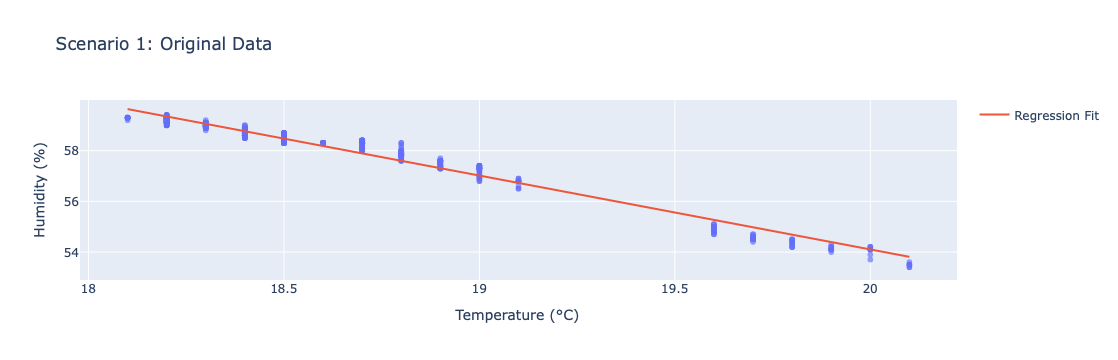

Saved plot as scenario1_original.png

=== Scenario 2: Filtered (20–35 °C) ===
Slope: -5.810
Intercept: 170.257
R²: 0.842
Samples: 16


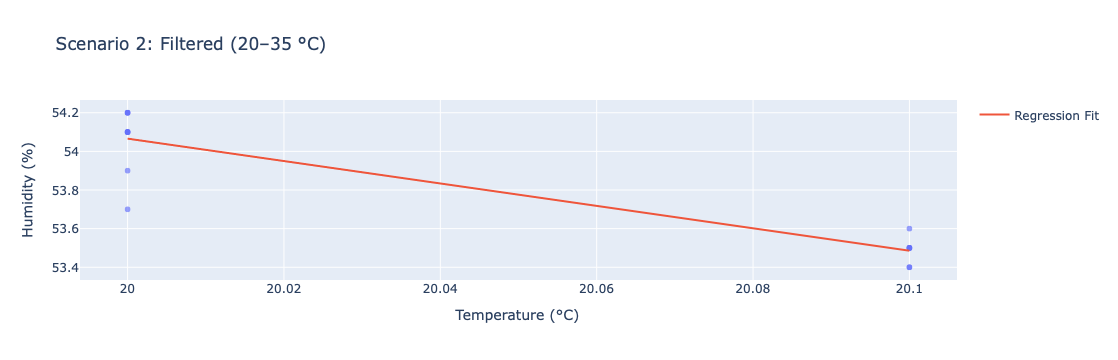

Saved plot as scenario2_filtered.png
Skipping =====  Scenario 3: More Filtered (22–32 °C)   ==== — no data points in this range.


In [32]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression

# Load your dataset
sensor_data = pd.read_csv("sensor_data.csv")

# Function to fit regression, plot, print metrics, and save PNG
def plot_regression(df, title, filename):
    if df.empty:
        print(f"Skipping {title} — no data points in this range.")
        return None
    
    X = df[["temperature"]].values
    y = df["humidity"].values

    model = LinearRegression()
    model.fit(X, y)

    # Predictions
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range = model.predict(x_range)

    slope, intercept, r2 = model.coef_[0], model.intercept_, model.score(X, y)

    # Print metrics in notebook
    print(f"\n=== {title} ===")
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"Samples: {len(df)}")

    # Scatter + regression line
    fig = px.scatter(df, x="temperature", y="humidity", opacity=0.65, title=title)
    fig.add_traces(go.Scatter(x=x_range.flatten(), y=y_range, name="Regression Fit"))
    fig.update_layout(xaxis_title="Temperature (°C)", yaxis_title="Humidity (%)")
    
    # Show in Jupyter
    fig.show()

    # Save image for report
    fig.write_image(filename)
    print(f"Saved plot as {filename}")
    return fig

# Scenario 1: Original Data
plot_regression(sensor_data, "Scenario 1: Original Data", "scenario1_original.png")

# Scenario 2: Filtered (20–35 °C)
df_filtered = sensor_data[(sensor_data["temperature"] >= 20) & (sensor_data["temperature"] <= 35)]
plot_regression(df_filtered, "Scenario 2: Filtered (20–35 °C)", "scenario2_filtered.png")

# Scenario 3: More Filtered (22–32 °C)
df_more_filtered = sensor_data[(sensor_data["temperature"] >= 22) & (sensor_data["temperature"] <= 32)]
plot_regression(df_more_filtered, "=====  Scenario 3: More Filtered (22–32 °C)   ====", "scenario3_filtered.png")
